In [28]:
from pathlib import Path
from functools import partial
import xml.etree.ElementTree as ET #For reading and writing XML files
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import minimize
from rdkit import Chem
from rdkit.Chem import rdMolTransforms
from ase.units import Hartree, kcal, mol
kcalmol = kcal / mol

def parseQMoptE(orcaoutfile):
    lines = Path(orcaoutfile).read_text().split("\n")
    energy = float(np.nan)
    for i,line in enumerate(lines):
        if "*** OPTIMIZATION RUN DONE ***" in line:
            energy = float(lines[i-3].split()[4])
    QMopt_E = energy * Hartree / kcalmol

    return QMopt_E

def curve_fit(angles,energies):
    func = interpolate.interp1d(x=angles, y=energies, kind="cubic")
    probe_angs = list(range(-180,181,1))
    pred_energies = [func(ang) for ang in probe_angs]
    min_E = min(pred_energies)
    min_ang = probe_angs[pred_energies.index(min_E)]
    # print(min_ang)
    try:
        res = minimize(func,min_ang) # min_ang is the initial guess (as local minimum)
        # other options:
        # method: If not given, chosen to be one of BFGS, L-BFGS-B, SLSQP, depending on whether or not the problem has constraints or bounds.
    
        # But actually, because of the step of constrain but not fix in xtb optimization step,
        # There should be error which cannot be cancelled by minimization
        if res.success:
            min_ang = res.x[0] # min_ang
            min_E = res.fun if not isinstance(res.fun, list) else res.fun[0]# min_energy
    except ValueError: # in case out of range(-180, 180)
        min_ang = min_ang
        min_E = min_E
    rel_E = energies - min_E

    return rel_E, func, min_E

def QMoptE_list(optlogpath,angles=list(range(-180,181,15))):
    QMoptEs = []
    try:
        for ang in range(-180,180,15):
            strang = "%03d" % ang
            logfile = list(optlogpath.glob(f"*_{strang}.*.log"))[0]
            QMoptEs.append(parseQMoptE(logfile))
        QMoptEs.append(QMoptEs[0])
    except:
        print("qmopt parse error")
    rel_E, func, min_E = curve_fit(angles,np.array(QMoptEs))

    return rel_E, func, min_E

def CSD_hist(TorsionSmartsPattern, TorLibXMLfile):
    tree = ET.parse(TorLibXMLfile)
    root = tree.getroot()
    for torsionRule in root.iter("torsionRule"): #Loop again
        if TorsionSmartsPattern == torsionRule.get("smarts"):
            # bins = list(torsionRule.find("histogram_shifted").findall("bin")) # for analysis
            bins = list(torsionRule.find("histogram").findall("bin")) # for view
            bincounts = [ int(bin.get("count")) for bin in bins ]
            break
            
    return bincounts

def CSDTEU_list(TorsionSmartsPattern, TorLibXMLfile):
    from math import ceil
    tree = ET.parse(TorLibXMLfile)
    root = tree.getroot()
    for torsionRule in root.iter("torsionRule"): #Loop again
        if TorsionSmartsPattern == torsionRule.get("smarts"):
            # bins = list(torsionRule.find("histogram_shifted").findall("bin")) # for analysis
            bins = list(torsionRule.find("histogram_converted").findall("bin")) # for view
            hist_E = [ float(bin.get("energy")) for bin in bins ] # only for those "specific" and "exact"
            break
    probe_angs = list(range(-180,181,1))
    TEU_energies = []
    for theta in probe_angs:
        bin_num = ceil(theta / 10) + 17
        energy = (hist_E[bin_num]-hist_E[(bin_num+35)%36])/10.0*(theta-(bin_num-17)*10)+hist_E[bin_num]
        TEU_energies.append(energy)

    return TEU_energies

def sdf_ang_list(sdffile, torquartet):
    mols = Chem.SDMolSupplier(sdffile)
    idxr1,idxr2,idxr3,idxr4 = torquartet
    degs = []
    for mol in mols:
        deg = rdMolTransforms.GetDihedralDeg(mol.GetConformer(),idxr1,idxr2,idxr3,idxr4)
        degs.append(deg)
    return degs

def get_map_index(refsdffile, probesdffile):
    mol1 = Chem.SDMolSupplier(refsdffile)[0]
    mol2 = Chem.SDMolSupplier(probesdffile)[0]
    
    canonical_mol1 = Chem.MolFromSmiles(Chem.MolToSmiles(mol1,isomericSmiles=False))
    # print(Chem.MolToSmiles(canonical_mol1))
    # print(list(map(int, mol1.GetProp("_smilesAtomOutputOrder")[1:-2].split(","))))
    
    canonical_mol2 = Chem.MolFromSmiles(Chem.MolToSmiles(mol2,isomericSmiles=False))
    # print(Chem.MolToSmiles(canonical_mol2))
    # print(list(map(int, mol2.GetProp("_smilesAtomOutputOrder")[1:-2].split(","))))
    
    mapindex = dict(zip(
        list(map(int, mol1.GetProp("_smilesAtomOutputOrder")[1:-2].split(","))),
        list(map(int, mol2.GetProp("_smilesAtomOutputOrder")[1:-2].split(","))),
        ))
    return mapindex

Plot func

In [29]:
def plotall(smarts,bincounts,func,min_E,rel_E,TEU_energies,degstatistics,xtaldeg,):
    # fig = plt.figure()
    fig, axs = plt.subplots(1, 3, figsize=(45, 10), sharex=True, sharey=True)
    # 1. plot_TEU
    # ax1 = fig.add_subplot(111)
    for num in range(3):
        if num == 0:
            ax1 = axs[num]
            ax1.set_ylim(0,10000)
            x = list(range(-175,180,10))
            ax1.bar(x,bincounts, width=10, color="b",align="center",edgecolor="black",label="CSD histogram")
            # 2. plot_QMoptE
            angles = list(range(-180,181,15))
            probe_angs = list(range(-180,181,1))
            ax2 = ax1.twinx()
            lns1 = ax2.plot(probe_angs, np.array([ func(ang) for ang in probe_angs ]) - min_E, color = "black",label="QM fragment", linewidth=5)
            ax2.plot(angles, rel_E, color="red", marker="^", markersize=10,linestyle="")
            ax2.set_ylim(0,20)

            # 3. plot CSD-TEU
            lns2 = ax2.plot(probe_angs, TEU_energies, color="blue", label="CSD TEU",linewidth=5)
            lns = lns1+lns2
            labs = [l.get_label() for l in lns]

            # plt.close()
            plt.xlim(-185,185)
            x_major_locator = MultipleLocator(30) # The sep is set to 30
            ax = plt.gca() # the instance of 2 axes
            ax.xaxis.set_major_locator(x_major_locator)
            # plt.figure()
            font1 = {"family": "Helvetica", "weight": "normal", "size": 30}
            font2 = {"family": "Helvetica", "weight": "normal", "size": 23}
            ax1.set_title(smarts, font1)
            ax1.set_xlabel("Angle(degree)",font2)
            ax1.set_ylabel("CSD histogram count",font2)
            ax2.set_ylabel("QM relE(kcal/mol) or CSD TEU",font2)
            # ax2.plot(probe_angs, TEU_energies, color="black", marker="o", markersize=5,linestyle="")
            ax1.tick_params(labelsize=23)
            ax2.tick_params(labelsize=23)
            ax2.legend(lns, labs, loc="upper right",prop={"size":23})
            
        else:
            ax1 = axs[num]
            degs = degstatistics[num-1]
            ax1.hist(degs, bins=int(360/10), range=[-180,180],edgecolor="black")
            ax1.set_ylim(0,1000)
            ax2 = ax1.twinx()
            lns1 = ax2.plot(probe_angs, np.array([ func(ang) for ang in probe_angs ]) - min_E, color = "black",label="QM fragment", linewidth=5)
            ax2.plot(angles, rel_E, color="red", marker="^", markersize=10,linestyle="")
            ax2.set_ylim(0,20)
            lns2 = ax2.plot(probe_angs, TEU_energies, color="blue", label="CSD TEU",linewidth=5)
            ax1.tick_params(labelsize=23)
            ax2.tick_params(labelsize=23)
        plt.axvline(x=xtaldeg,color="red",linestyle="--")
        plt.axhline(y=1.7,color="blue", linestyle="--")
        
    axs[1].set_title("nofilter",font1)
    axs[2].set_title("filter",font1)
    plt.show()
    # plt.savefig(outpath / f"{subdir}.png")
    plt.close()



Main

sel @/serialNumber=1 @/serialNumber=11 @/serialNumber=18 @/serialNumber=16
sel @/serialNumber=19 @/serialNumber=18 @/serialNumber=2 @/serialNumber=3


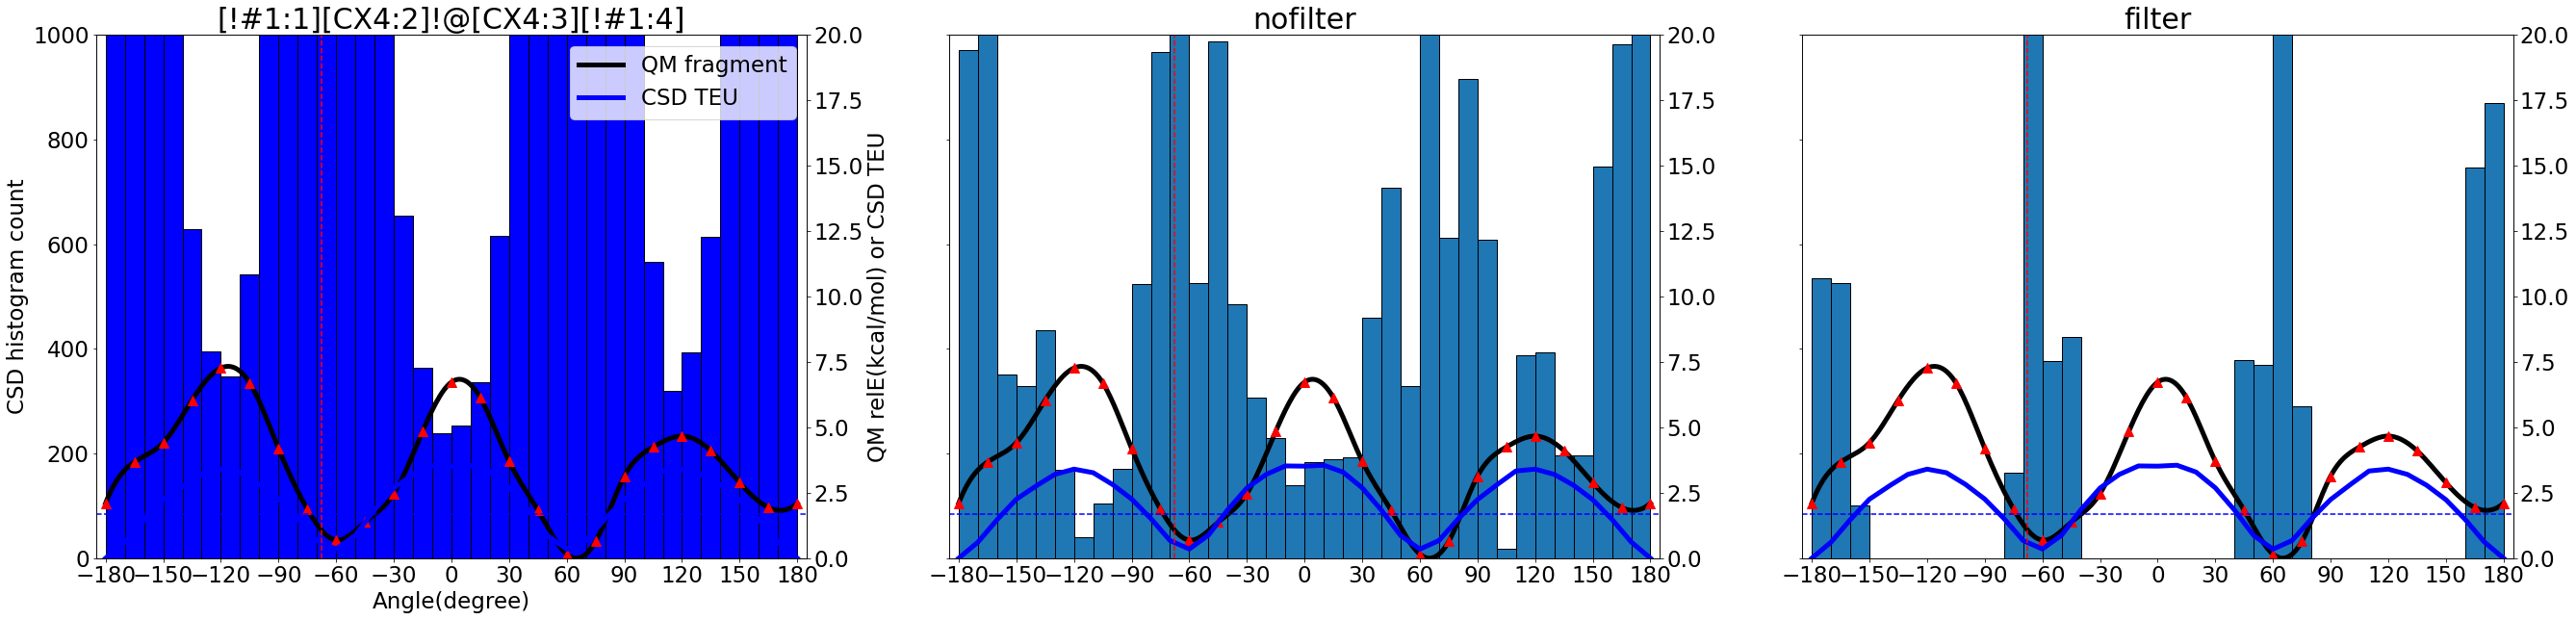

sel @/serialNumber=13 @/serialNumber=14 @/serialNumber=19 @/serialNumber=17
sel @/serialNumber=16 @/serialNumber=8 @/serialNumber=7 @/serialNumber=5


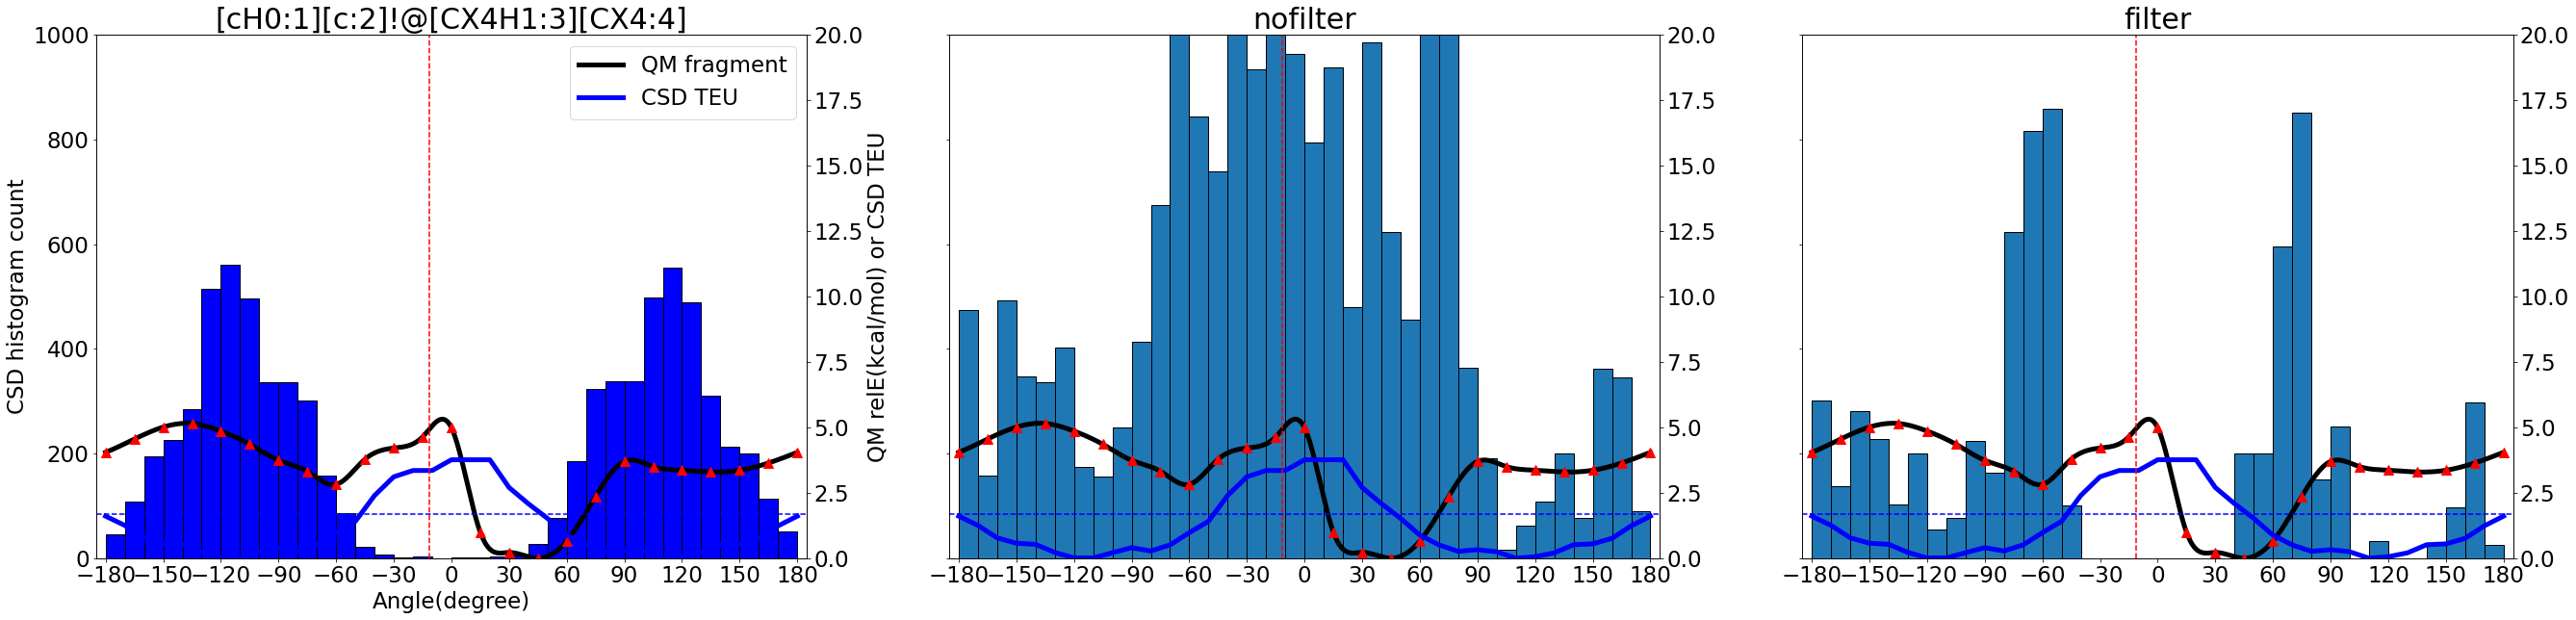

In [37]:

# xmlfile = "/pubhome/qcxia02/Downloads/dataset/tor_lib/tor_lib_2020.xml"
# xmlfile = 'TorLibv21WCSDBins.xml'
xmlfile = "/pubhome/qcxia02/work/confgen/src/strain/TL_2.1_VERSION_6.xml"
# TS = ['[a:1][a:2]!@[NH1:3][C,c:4]', '[O:1]=[CX3:2]!@[NX3H1:3][!#1:4]', '[c:1][cr6:2]!@[cr6:3][cH0:4]', '[cH0:1][c:2]!@[CX4H1:3][CX4:4]', '[a:1][a:2]!@[CX3:3]=[O:4]']
# TQ = [[10, 25, 7, 20], [3, 20, 7, 25], [21, 26, 28, 23], [25, 27, 31, 18], [6, 24, 20, 3]]
TS = ['[!#1:1][CX4:2]!@[CX4:3][!#1:4]', '[cH0:1][c:2]!@[CX4H1:3][CX4:4]']
TQ = [[0, 10, 17, 15], [12, 13, 18, 16]]
# inpdbid = "5dwr"
inpdbid = "1nc3"
xtalligpath = "/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/rdkit_Pfrag/pdbbind_mol2s"
dockpath = f"/pubhome/qcxia02/work/confgen/dock/{inpdbid}/blastermaster"
qmgopath = "/pubhome/qcxia02/git-repo/TorsionNet/RDK_torsion/rdkit_Pfrag/outputs/PDB/4QMGO"

for i in range(len(TS)):
    xtalligsdf = f"{xtalligpath}/{inpdbid}.sdf"
    # sdffiles = [f"{dockpath}/dockingT_c100b10/test.sdf",f"{dockpath}/dockingT_c100b10d38/test.sdf"]
    # sdffiles = [f"{dockpath}/dockingT_c250b10/test.sdf",f"{dockpath}/dockingT_c250b10d38/test.sdf"]
    sdffiles = [f"{dockpath}/dockingT_c1000b10/test.sdf",f"{dockpath}/dockingT_c1000b10d38/test.sdf"]
    optlogpath = Path(f"{qmgopath}/{inpdbid}_{i}")
    mapindex = get_map_index(xtalligsdf, sdffiles[0])
    smarts = TS[i]
    torquartet = TQ[i]
    modtorquartet = [ mapindex[i] for i in torquartet ]
    print(f"sel @/serialNumber={torquartet[0]+1} @/serialNumber={torquartet[1]+1} @/serialNumber={torquartet[2]+1} @/serialNumber={torquartet[3]+1}")
    print(f"sel @/serialNumber={modtorquartet[0]+1} @/serialNumber={modtorquartet[1]+1} @/serialNumber={modtorquartet[2]+1} @/serialNumber={modtorquartet[3]+1}")
    bincounts = CSD_hist(smarts, xmlfile) # result is the same as that in Torsion Analyzer
    rel_E, func, min_E = QMoptE_list(optlogpath=optlogpath) # QMoptE related infos
    TEU_energies = CSDTEU_list(smarts, xmlfile)
    sdffunc1 = partial(sdf_ang_list, torquartet=torquartet)
    sdffunc2 = partial(sdf_ang_list, torquartet=modtorquartet)
    degstatistics = list(map(sdffunc2, sdffiles))
    xtaldeg = sdffunc1(xtalligsdf)[0]
    plotall(
        smarts,bincounts,func,min_E,rel_E,TEU_energies,degstatistics,xtaldeg
)


In [74]:
print(xtaldeg)

-9.836218101694392


CC1CC([NH3+])CC(c2ccncc2NC(=O)c2ccc(F)c(-c3c(F)cccc3F)n2)C1
[8, 30, 17, 29, 4, 18, 31, 27, 12, 9, 5, 10, 25, 7, 20, 3, 24, 16, 15, 21, 0, 26, 28, 22, 1, 13, 11, 14, 23, 2, 6, 19]
CC1CC([NH3+])CC(c2ccncc2NC(=O)c2ccc(F)c(-c3c(F)cccc3F)n2)C1
[23, 21, 20, 18, 19, 17, 16, 11, 12, 13, 14, 15, 10, 9, 7, 8, 4, 5, 6, 1, 0, 2, 24, 25, 26, 27, 28, 29, 30, 31, 3, 22]


1
